<a href="https://colab.research.google.com/github/victoriadarosa/assignment4/blob/main/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [ ]:
! git clone https://www.github.com/DS3001/assignment4

Cloning into 'assignment4'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (8/8), 265.63 KiB | 1.04 MiB/s, done.


In [ ]:
import numpy as np  # Import NumPy
import pandas as pd  # Import Pandas
import seaborn as sns # Import Seaborn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [ ]:
def pn(x):
    print(x,'\n')

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [ ]:
#1.1 load the data
df = pd.read_csv('./assignment4/data/cars_hw.csv')

In [ ]:
#1.2 clean the data
#clean price var with windsorize
#price range is really off? don't know how to fix, don't know what its saying now
df.head()

# Compute IQR and 1st, 3rd quantiles for Mileage_Run
pct25, pct75 = np.percentile(df.Price, [25, 75])
iqr = pct75 - pct25
# Compute whiskers:
lower_whisker = pct25 - iqr*1.5
upper_whisker = pct75 + iqr*1.5
outliers2 = df[(df['Price'] < lower_whisker) | (df['Price'] > upper_whisker)]

def windsorize(x):
  # Windsorize x:
  x_windsor = x
  x_windsor[x < lower_whisker] = lower_whisker
  x_windsor[x > upper_whisker] = upper_whisker
  return(x_windsor)

windsorize(df.Price)

<ipython-input-5-50434d6b7fee>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[x < lower_whisker] = lower_whisker
<ipython-input-5-50434d6b7fee>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[x > upper_whisker] = upper_whisker


0       657000
1       682000
2       793000
3       414000
4       515000
        ...   
971     956000
972    1027000
973     736000
974     749000
975     691000
Name: Price, Length: 976, dtype: int64

I decided to clean the Price variable because it seems the prices for the cars were unreasonably high, assuming it was recorded us USD.

In [ ]:
#2.1 summarize the price variable
price = 'Price'
make = 'Make'
price_summary = df.groupby(make)[price].describe()
print(price_summary)


               count          mean            std        min         25%  \
Make                                                                       
Chevrolet        6.0  4.535000e+05  246606.366503   267000.0   288500.00   
Datsun           3.0  2.896667e+05   10503.967504   279000.0   284500.00   
Ford            52.0  7.211731e+05  140927.699605   290000.0   635000.00   
Honda           73.0  7.983818e+05  264893.305869   316000.0   581000.00   
Hyundai        305.0  6.910783e+05  276437.697587   248000.0   485000.00   
Jeep             4.0  1.442906e+06  101937.500000  1290000.0  1442906.25   
Kia              8.0  1.478266e+06   44149.979650  1369000.0  1493875.00   
MG Motors       35.0  1.493875e+06       0.000000  1493875.0  1493875.00   
Mahindra        18.0  1.100167e+06  175549.305961   796000.0  1037000.00   
Maruti Suzuki  293.0  5.887850e+05  216019.860943   237000.0   411000.00   
Nissan           4.0  8.842500e+05  289559.867155   475000.0   782500.00   
Renault     

<ipython-input-7-06b9849d8328>:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=price, hue=make)


<Axes: xlabel='Price', ylabel='Density'>

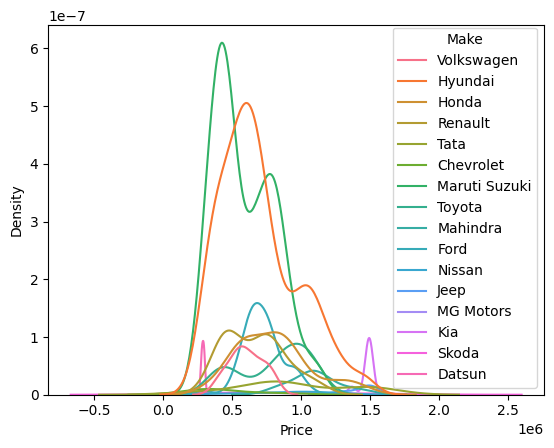

In [ ]:
#2.2 make kernel plot
sns.kdeplot(data=df, x=price, hue=make)

Skoda has the highest price, but MG Motors has the highest price of cars with a large density.

In [ ]:
#3 split the data
train_set, test_set = train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
#4.1 regress price on the numeric variables
y = df[price]
num_vars = ['Mileage_Run', 'Seating_Capacity', 'Make_Year']
X1 = df.loc[:,num_vars]

# print(X1.head())

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model

pn(reg.score(X1, y)) # R squared measure
y_pred = reg.predict(X_test)
pn(np.sqrt(mean_squared_error(y_test, y_pred)))

0.35270063917606365 

243861.06360667918 



In [ ]:
#4.2 model comprised of one-hot encoded regressors
cat_vars = ['Make', 'Color', 'Body_Type', 'No_of_Owners', 'Fuel_Type', 'Transmission', 'Transmission_Type']

#used this website to make categorical columns to be numeric: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
cat_features = pd.get_dummies(df, columns=cat_vars)
cat_features.drop(columns = ['Price', 'Make_Year', 'Mileage_Run', 'Seating_Capacity'], inplace=True)

X2 = cat_features

# print(X2.head())

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

pn(reg.score(X2, y)) # R squared measure
y_pred = reg.predict(X_test)
pn(np.sqrt(mean_squared_error(y_test, y_pred)))

0.7259558192971146 

173507.54692334338 



From the previous two model, the model that regresses on catgorical variable performs better than the model that regresses on numeric variables.

In [ ]:
#4.3 combine all the regressors
all_regressors = pd.concat([X1, X2], axis=1)
X3 = all_regressors
# all_regressors.head()

X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model

pn(reg.score(X3, y)) # R squared measure
y_pred = reg.predict(X_test)
pn(np.sqrt(mean_squared_error(y_test, y_pred)))



0.838042898640412 

136123.80178262142 



The joint model performs the best out of all of the models. The r-squared for the joint model is 0.84, the r-squared for the numberic model is 0.35, and the r-squared categorical model is 0.73.

In [ ]:
#5.1 PolynomialFeatures function from sklearn

x = X3
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(x) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

X_train, X_test, y_train, y_test = train_test_split(zdf, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model

pn(reg.score(zdf, y)) # R squared measure
y_pred = reg.predict(X_test)
pn(np.sqrt(mean_squared_error(y_test, y_pred)))

-4249207.201936625 

1431742782.186986 



In [ ]:
#5.2 PolynomialFeatures function from sklearn
x = X3
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z = expander.fit_transform(x) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

X_train, X_test, y_train, y_test = train_test_split(zdf, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model

pn(reg.score(zdf, y)) # R squared measure
y_pred = reg.predict(X_test)
pn(np.sqrt(mean_squared_error(y_test, y_pred)))

#a larger mean_squared_error means more error

-18639.326481482676 

94828173.25109686 



R-squares and the RMSE improve as the degree expands. R-squared is negative for both models. The r-squared and RMSE for the best model with the expander is -18639.33 and 94828173.25. This model performs worse than the best model from part 3 as the r-squared and RMSE for the best model in part 3 was 0.84 and 136123.80.

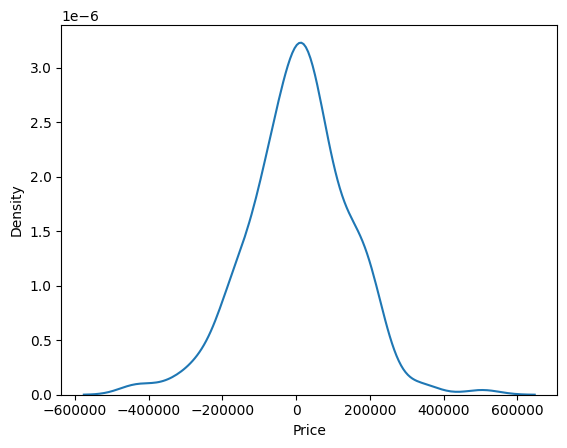

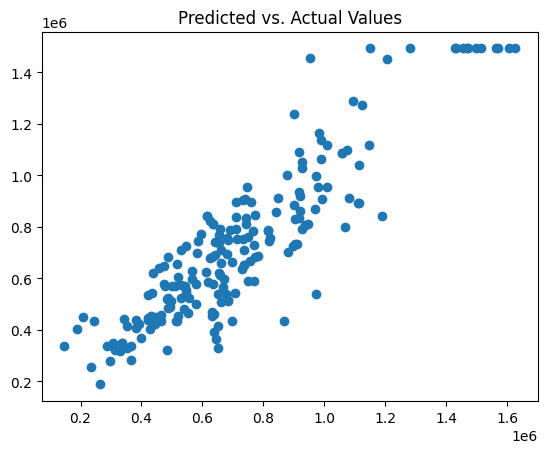

In [ ]:
#6 predicted values for the test data and plot them against the true values
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

# Predicted values:
y_hat_lm = reg.predict(X_test)
residuals_lm = y_test - y_hat_lm

## Residual plot:
sns.kdeplot(residuals_lm)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_lm,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

The predicted values do roughly line up along the diagonal, except for a few outlier values in tge top right corner of the graph. This is most likely caused by me windsorizing the Price variable. Additionally, the residual graph is roughly bell-shaped.

Accuracy:  0.5 

0.7527879521856032 

154137.6622800965 



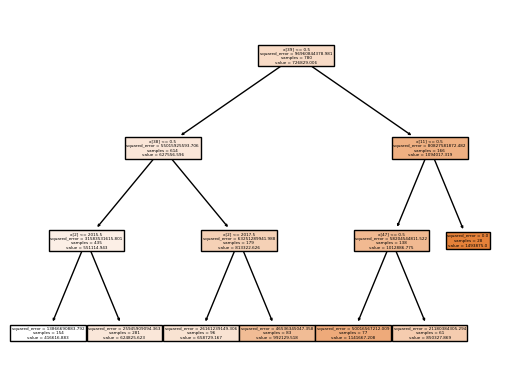

In [ ]:
#7.1 matrix of regressors/features

## Splitting the Sample into Train/Test Sets:
from sklearn.model_selection import train_test_split

## Preprocess Data:
y = df['Price']
X = X3

## Split the Sample into Training and Testing Sets:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=104)

## Fit the Model
from sklearn import tree # Import the tree classifier
cart = tree.DecisionTreeRegressor(max_depth = 3) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

## Print tree
tree.plot_tree(cart,filled=True)

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

## Confusion Matrix
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
print('Accuracy: ', acc, '\n')
pd.crosstab(y_test,y_hat)

pn(cart.score(X_test, y_test))
pn(np.sqrt(mean_squared_error(y_test, y_hat)))


Accuracy:  0.5 

0.8144258537780303 

133546.55443447703 



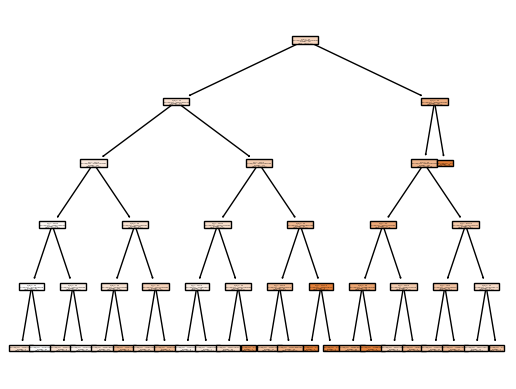

In [ ]:
#7.2 matrix of regressors/features

## Splitting the Sample into Train/Test Sets:
from sklearn.model_selection import train_test_split

## Preprocess Data:
y = df['Price']
X = X3

## Split the Sample into Training and Testing Sets:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=104)

## Fit the Model
from sklearn import tree # Import the tree classifier
cart2 = tree.DecisionTreeRegressor(max_depth = 5) # Create a classifier object
cart2 = cart2.fit(X_train, y_train) # Fit the classifier

## Print tree
tree.plot_tree(cart2,filled=True)

## Make Predictions on the Test Set
y_hat = cart2.predict(X_test)

## Confusion Matrix
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
print('Accuracy: ', acc, '\n')
pd.crosstab(y_test,y_hat)

pn(cart2.score(X_test, y_test))
pn(np.sqrt(mean_squared_error(y_test, y_hat)))

Accuracy:  0.5 

0.7631149576294309 

150883.8549530065 



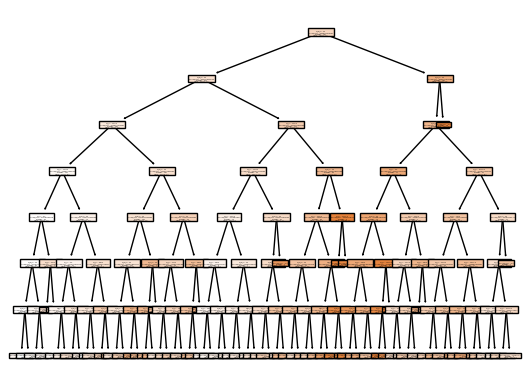

In [ ]:
#7.3 matrix of regressors/features

## Splitting the Sample into Train/Test Sets:
from sklearn.model_selection import train_test_split

## Preprocess Data:
y = df['Price']
X = X3

## Split the Sample into Training and Testing Sets:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=104)

## Fit the Model
from sklearn import tree # Import the tree classifier
cart = tree.DecisionTreeRegressor(max_depth = 7) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

## Print tree
tree.plot_tree(cart,filled=True)

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

## Confusion Matrix
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
print('Accuracy: ', acc, '\n')
pd.crosstab(y_test,y_hat)

pn(cart.score(X_test, y_test))
pn(np.sqrt(mean_squared_error(y_test, y_hat)))

The tree with the depth of 5 gives the best results.

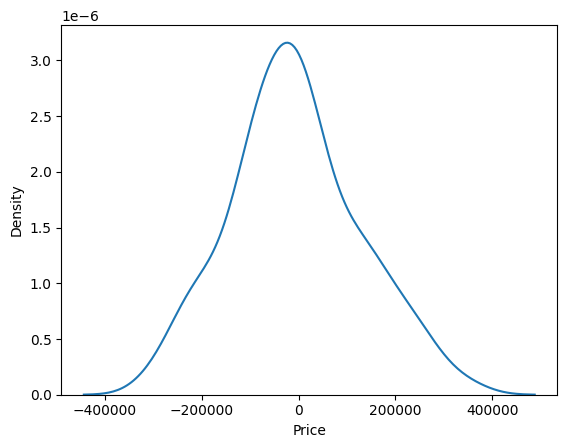

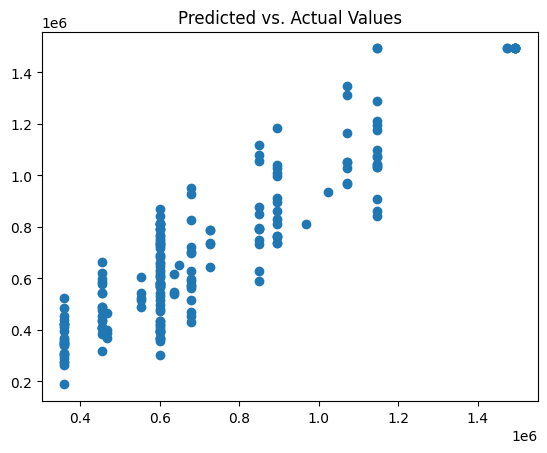

In [ ]:
#8 determine the predicted values for the test data

# Predicted values:
y_hat_t = cart2.predict(X_test)
residuals_t = y_test - y_hat_t

## Residual plot:
sns.kdeplot(residuals_t)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_t,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

9. The linear models performed better than the tree models. The r-sqaured and rmse values for all the linear models performed better than the r-squared and rmse values for the best tree model, meaning the linear models were more accurate.

Side note: not sure if my rmse values should be that large, but in the future I would look more into cleaning the data so help fix that.

The predicted values do roughly line up along the diagonal, except for a few outlier values in tge top right corner of the graph. This is most likely caused by me windsorizing the Price variable. Additionally, the residual graph is roughly bell-shaped.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [ ]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree

In [ ]:
#1.1 load the data
cm = pd.read_csv('./assignment4/data/contraception_hw.csv')

In [ ]:
#1.2 tabulate the method variable
method = 'method'
noc = 'numberChildren'
cm[method].value_counts()
pd.crosstab(cm[method], cm[noc])

numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


1.3 Generally speaking, couples who used no contraceptions had less kids.

In [ ]:
#2 split the sample
y = cm[method]
X = cm.drop([method], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=104)

[Text(0.3333333333333333, 0.9, 'x[0] <= 415.5\nsquared_error = 0.763\nsamples = 1178\nvalue = 1.928'),
 Text(0.2222222222222222, 0.7, 'squared_error = 0.0\nsamples = 322\nvalue = 1.0'),
 Text(0.4444444444444444, 0.7, 'x[0] <= 1001.5\nsquared_error = 0.604\nsamples = 856\nvalue = 2.277'),
 Text(0.2222222222222222, 0.5, 'x[0] <= 642.5\nsquared_error = 0.237\nsamples = 473\nvalue = 2.613'),
 Text(0.1111111111111111, 0.3, 'squared_error = 0.0\nsamples = 183\nvalue = 2.0'),
 Text(0.3333333333333333, 0.3, 'squared_error = 0.0\nsamples = 290\nvalue = 3.0'),
 Text(0.6666666666666666, 0.5, 'x[0] <= 1214.5\nsquared_error = 0.746\nsamples = 383\nvalue = 1.862'),
 Text(0.5555555555555556, 0.3, 'squared_error = 0.0\nsamples = 173\nvalue = 1.0'),
 Text(0.7777777777777778, 0.3, 'x[0] <= 1320.5\nsquared_error = 0.245\nsamples = 210\nvalue = 2.571'),
 Text(0.6666666666666666, 0.1, 'squared_error = 0.0\nsamples = 90\nvalue = 2.0'),
 Text(0.8888888888888888, 0.1, 'squared_error = 0.0\nsamples = 120\nvalu

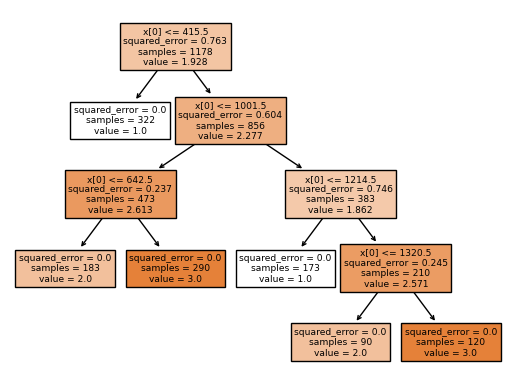

In [ ]:
#3.1 regression tree
rt = tree.DecisionTreeRegressor()
rt = rt.fit(X_train, y_train)
tree.plot_tree(rt,filled=True)

3.2
The leaf nodes in the tree are assigned numerical values, such as 1.0, 2.0, and 3.0. However, this seems counterintuitive since the primary purpose of the tree was to predict contraception methods, represented by categorical values 1, 2, and 3, rather than continuous numerical values. The issue here comes from the treatment of these numbers as real numbers, when, in fact, they should represent categories corresponding to no birth control use, short-term birth control use, and long-term birth control use.

[Text(0.25, 0.9166666666666666, 'x[0] <= 415.5\ngini = 0.649\nsamples = 1178\nvalue = [495, 273, 410]'),
 Text(0.125, 0.75, 'gini = 0.0\nsamples = 322\nvalue = [322, 0, 0]'),
 Text(0.375, 0.75, 'x[0] <= 642.5\ngini = 0.628\nsamples = 856\nvalue = [173, 273, 410]'),
 Text(0.25, 0.5833333333333334, 'gini = 0.0\nsamples = 183\nvalue = [0, 183, 0]'),
 Text(0.5, 0.5833333333333334, 'x[0] <= 1001.5\ngini = 0.545\nsamples = 673\nvalue = [173, 90, 410]'),
 Text(0.375, 0.4166666666666667, 'gini = 0.0\nsamples = 290\nvalue = [0, 0, 290]'),
 Text(0.625, 0.4166666666666667, 'x[0] <= 1214.5\ngini = 0.643\nsamples = 383\nvalue = [173, 90, 120]'),
 Text(0.5, 0.25, 'gini = 0.0\nsamples = 173\nvalue = [173, 0, 0]'),
 Text(0.75, 0.25, 'x[0] <= 1320.5\ngini = 0.49\nsamples = 210\nvalue = [0, 90, 120]'),
 Text(0.625, 0.08333333333333333, 'gini = 0.0\nsamples = 90\nvalue = [0, 90, 0]'),
 Text(0.875, 0.08333333333333333, 'gini = 0.0\nsamples = 120\nvalue = [0, 0, 120]')]

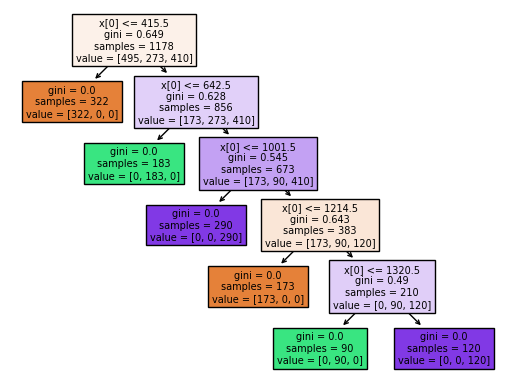

In [ ]:
#4.1 classification tree
ct = tree.DecisionTreeClassifier()
ct = ct.fit(X_train, y_train)
tree.plot_tree(ct,filled=True)

4.2 Tree looks different from previous tree because it includes a gini and multiple numbers for value. These number represent couples with no birth control, long term birth control, and short term birth control. This algorithm uses x[0] to determine the split, but this seems strange. Because it splits the couples based on x[0] (which is just an auto-increment id number), so it does not give us much information on the specifics of each couple. In the future, I would try splitting the data differently to see if that effects how the tree is made.


In [ ]:
#5.1 confusion matrix

## Make Predictions on the Test Set
y_hat = ct.predict(X_test)

## Confusion Matrix
tab = pd.crosstab(y_test,y_hat)
acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
print('Accuracy for Model Overall: ', acc, '\n')
pd.crosstab(y_test,y_hat)

Accuracy for Model Overall:  1.0 



col_0,1,2,3
method,,,
1,133,0,1
2,0,60,0
3,0,0,101


5.2 The accuracy for method 1 is 100%, the accuracy for method 2 is 100%, and the accuracy for model 3 is 99%.

6. You can't use a linear model for this exercise because linear models assume a linear relationship between input features and the target variable. The given problem does not showcase a linear relationship so it would not be helpful to use a linear model in this case.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?